# Text Mining

## Arbeiten mit Jupyter Notebooks


[Jupyter Notebooks](https://jupyter.org/) sind eine browserbasierte Oberfläche um mit Skriptsprachen, wie R, zu interagieren und bestehen aus bestehen aus *Zellen*. Die zwei wichtigsten Arten von Zellen sind:
+ Markdown Zellen für formatieren Text und
+ Code Zellen für Quelltext der ausgeführt werden soll.


Um Code in einer Zelle ausführbar zu machen können Sie beispielsweise folgenden Quelltext in das untere Textfeld kopieren   

```R
str_variable_name <- "Hallo Jupyter"
print(str_variable_name)
```

Um dann den Code in der Zelle auszuführen drücken Sie `Shift-Enter`

## Vergleichende Analyse von Twitter Profielen

Twitter spielt eine zuhnehmend wichtige rolle in der politischen Kommunikation. In diesem Notbook wird der Vergleich von der Aktivität von Bernd Riexinger (Die Linke) und Alice Weidel (AFD) besprochen. Sowohl [Bernd Riexinger](https://twitter.com/b_riexinger) als auch [Alice Weidel](https://twitter.com/Alice_Weidel) haben öffentlich zugägngliche Profiele auf Twitter. Im Notebook [get_tweets](./get_tweets.ipynb) werden diese aus Twitter geladen.

## Import der Daten

Im nächsen Schritt nutzen wird das R-Paket [lubridate](https://www.rdocumentation.org/packages/lubridate) um die Zeitstempel in R `date-time` Objekte zu konvertieren und einen ersten Blick auf die Verteilung der Häufigkeiten von Tweets zu werfen.

In [1]:
library(lubridate)
library(ggplot2)
library(dplyr)
library(readr)
library(tidyr)
library(scales)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘scales’

The following object is masked from ‘package:readr’:

    col_factor



In [2]:
tweets_1.csv <- read_csv("twitter_output/twitter_1.csv")
tweets_2.csv <- read_csv("twitter_output/twitter_2.csv")

Parsed with column specification:
cols(
  date = col_datetime(format = ""),
  username = col_character(),
  to = col_character(),
  replies = col_integer(),
  retweets = col_integer(),
  favorites = col_integer(),
  text = col_character(),
  geo = col_character(),
  mentions = col_character(),
  hashtags = col_character(),
  id = col_double(),
  permalink = col_character()
)
Parsed with column specification:
cols(
  date = col_datetime(format = ""),
  username = col_character(),
  to = col_character(),
  replies = col_integer(),
  retweets = col_integer(),
  favorites = col_integer(),
  text = col_character(),
  geo = col_character(),
  mentions = col_character(),
  hashtags = col_character(),
  id = col_double(),
  permalink = col_character()
)


In [3]:
tweets <- bind_rows(tweets_1.csv %>% mutate(collection = "b_riexinger"),
                    tweets_2.csv %>% mutate(collection = "Alice_Weidel")) 

In [4]:
head(tweets[, c("date", "username", "text")], n = 5)

date,username,text
2019-12-13 12:14:22,b_riexinger,Eigentlich ein klarer Auftrag an die #Groko. Vielleicht sollte @c_lindner inhaltlich auch nochmal nachjustieren! #Vermoegensteuer
2019-12-13 06:31:00,b_riexinger,"Unsere Gesellschaft hat sich in den letzten Jahren rapide gewandelt. @dagmarenkelmann, Mario Candeias, Alex Demirovic und Michael Brie haben sich dazu Gedanken gemacht. Bedenkenswert:"
2019-12-12 13:06:14,b_riexinger,"Ich wünsche allen Kolleginnen und Kollegen, die heute gegen die Lohnkürzungen bei #Karstadt streiken und demonstrieren viel Erfolg. Rückkehr zum #Flächentarifvertrag im Einzelhandel! Was sonst? #Streik #verdi"
2019-12-12 11:41:06,b_riexinger,"Viele machen sich über das franz. #Rentensystem lustig. Warum? Dort zahlen Arbeitnehmer 11,2% und Arbeitgeber 16,3%. In #Deutschland beide nur 9,3% - nur sollen die Arbeitnehmer hier noch privat vorsorgen +4%. Daher #Macron's #Rentenreform von oben und der #Streik von unten!"
2019-12-12 10:28:08,b_riexinger,Ich drücke heute der Labour Party und @JeremyCorbyn beide Daumen. #ForTheMany #ForTheManyNotTheFew


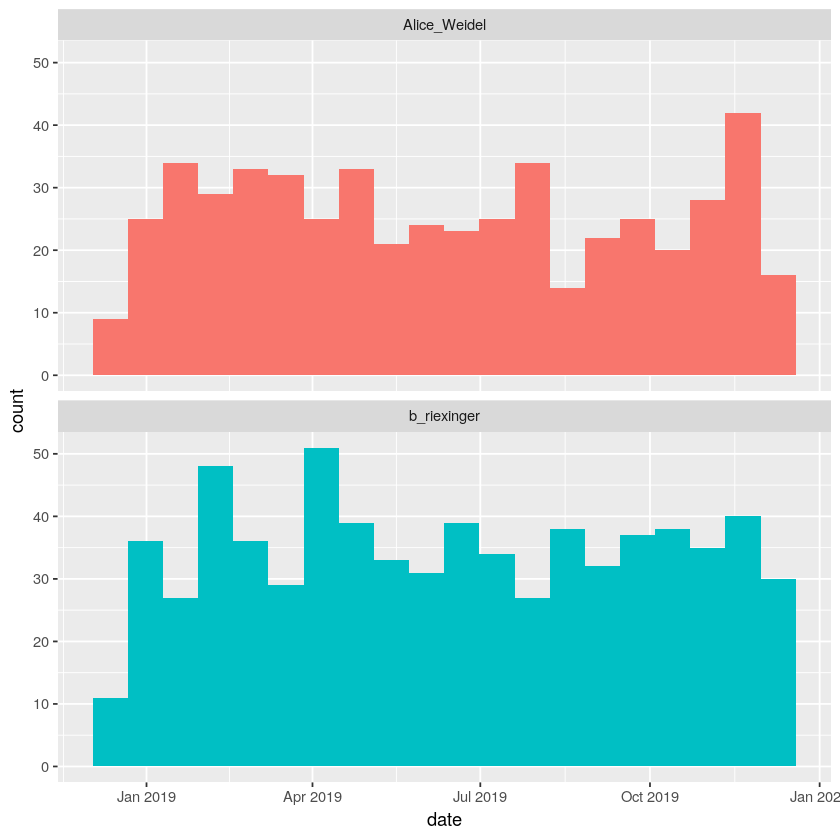

In [5]:
ggplot(tweets, aes(x = date, fill = collection)) +
  geom_histogram(position = "identity", bins = 20, show.legend = FALSE) +
  facet_wrap(~collection, ncol = 1)

## Frequenzanalyse

In [6]:
library(tidytext)
library(stringr)

In [7]:
stopwords <- get_stopwords(language = "de")$word

In [8]:
tidy_tweets <- tweets %>% 
  filter(!str_detect(text, "^RT")) %>%
  mutate(text = str_remove_all(text, "&amp;|&lt;|&gt;")) %>%
  unnest_tokens(word, text, token = "tweets") %>%
  filter(!word %in% stopwords,
         !word %in% str_remove_all(stopwords, "'"),
         str_detect(word, "[a-z]"),
         nchar(word) > 2,
        )

head(tidy_tweets, n = 5)

date,username,to,replies,retweets,favorites,geo,mentions,hashtags,id,permalink,collection,word
2019-12-13 12:14:22,b_riexinger,NA,7,40,203,NA,@c_lindner,#Groko #Vermoegensteuer,1.205461e+18,https://twitter.com/b_riexinger/status/1205460955120984064,b_riexinger,eigentlich
2019-12-13 12:14:22,b_riexinger,NA,7,40,203,NA,@c_lindner,#Groko #Vermoegensteuer,1.205461e+18,https://twitter.com/b_riexinger/status/1205460955120984064,b_riexinger,klarer
2019-12-13 12:14:22,b_riexinger,NA,7,40,203,NA,@c_lindner,#Groko #Vermoegensteuer,1.205461e+18,https://twitter.com/b_riexinger/status/1205460955120984064,b_riexinger,auftrag
2019-12-13 12:14:22,b_riexinger,NA,7,40,203,NA,@c_lindner,#Groko #Vermoegensteuer,1.205461e+18,https://twitter.com/b_riexinger/status/1205460955120984064,b_riexinger,#groko
2019-12-13 12:14:22,b_riexinger,NA,7,40,203,NA,@c_lindner,#Groko #Vermoegensteuer,1.205461e+18,https://twitter.com/b_riexinger/status/1205460955120984064,b_riexinger,vielleicht


Um ausschlieslich #HashTags zu extrahieren kann alternativ folgender Aufruf
```R
str_detect(word, "#[a-z]")
```
von `str_detect` verwendet werden.

In [9]:
frequency <- tidy_tweets %>% 
  group_by(collection) %>% 
  count(word, sort = TRUE) %>% 
  left_join(tidy_tweets %>% 
              group_by(collection) %>% 
              summarise(total = n())) %>%
  mutate(freq = n/total) %>% 
  filter(n > 5)

frequency %>% filter(collection == "Alice_Weidel") %>% head(n=10)

Joining, by = "collection"


collection,word,n,total,freq
Alice_Weidel,#afd,270,8725,0.030945559
Alice_Weidel,#bundestag,116,8725,0.013295129
Alice_Weidel,mehr,68,8725,0.007793696
Alice_Weidel,dass,51,8725,0.005845272
Alice_Weidel,bürger,42,8725,0.004813754
Alice_Weidel,deutschland,41,8725,0.004699140
Alice_Weidel,endlich,38,8725,0.004355301
Alice_Weidel,#deutschland,32,8725,0.003667622
Alice_Weidel,#staatsversagen,27,8725,0.003094556
Alice_Weidel,heute,27,8725,0.003094556


Analog können die `n` heufigsten Worter für Bernd Riexinger (b_riexinger) ausgegeben werden.

Eine alternative form für die Worthäufigkeiten kann weie folgt berechnet werden.

In [10]:
frequency <- frequency %>% 
  select(collection, word, freq) %>% 
  spread(collection, freq) %>% 
  arrange(Alice_Weidel, b_riexinger) %>% 
  na.omit()


frequency %>% head(n=10)

word,Alice_Weidel,b_riexinger
nutzen,0.0006876791,0.0005040746
stellt,0.0006876791,0.0005040746
frage,0.0006876791,0.0005880870
#verfassungsschutz,0.0006876791,0.0006720995
zusammen,0.0006876791,0.0006720995
partei,0.0006876791,0.0009241368
steuern,0.0006876791,0.0009241368
dürfen,0.0006876791,0.0012601865
#europa,0.0006876791,0.0014282114
arbeit,0.0006876791,0.0015962362


Die Daten sind nun in einer geigneten Form zur grafischen Darstellung. 

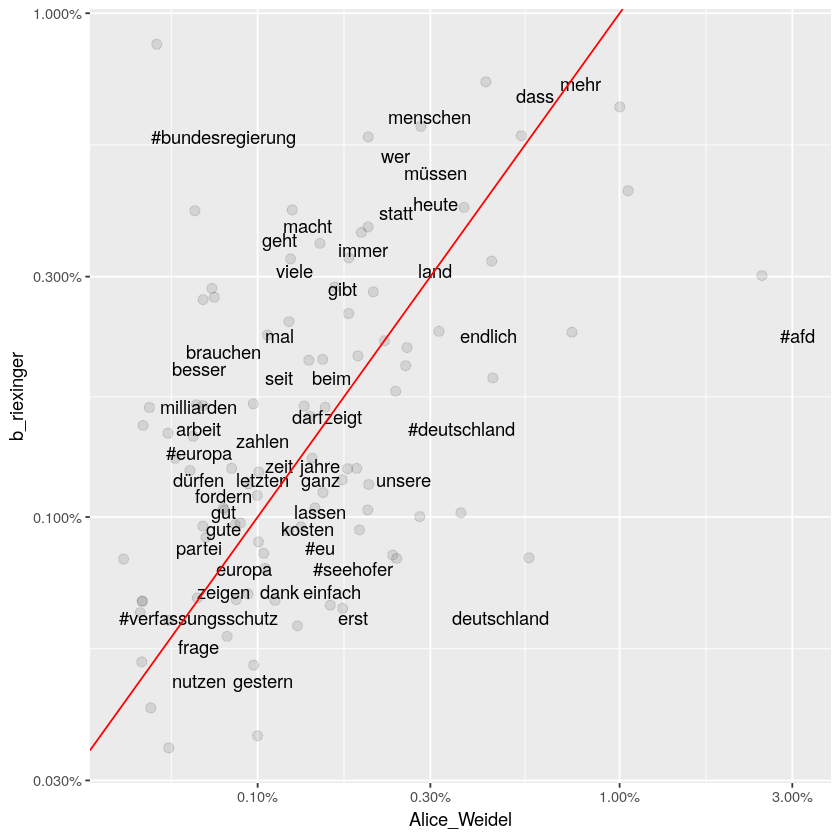

In [11]:
ggplot(frequency, aes(Alice_Weidel, b_riexinger)) +
  geom_jitter(alpha = 0.1, size = 2.5, width = 0.25, height = 0.25) +
  geom_text(aes(label = word), check_overlap = TRUE, vjust = 1.5) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  geom_abline(color = "red")

In der Grafik sehen wir die relative häufigkeit der wörter die von den beiden Politikern genutzt wurden.

## Neuer Abschnitt

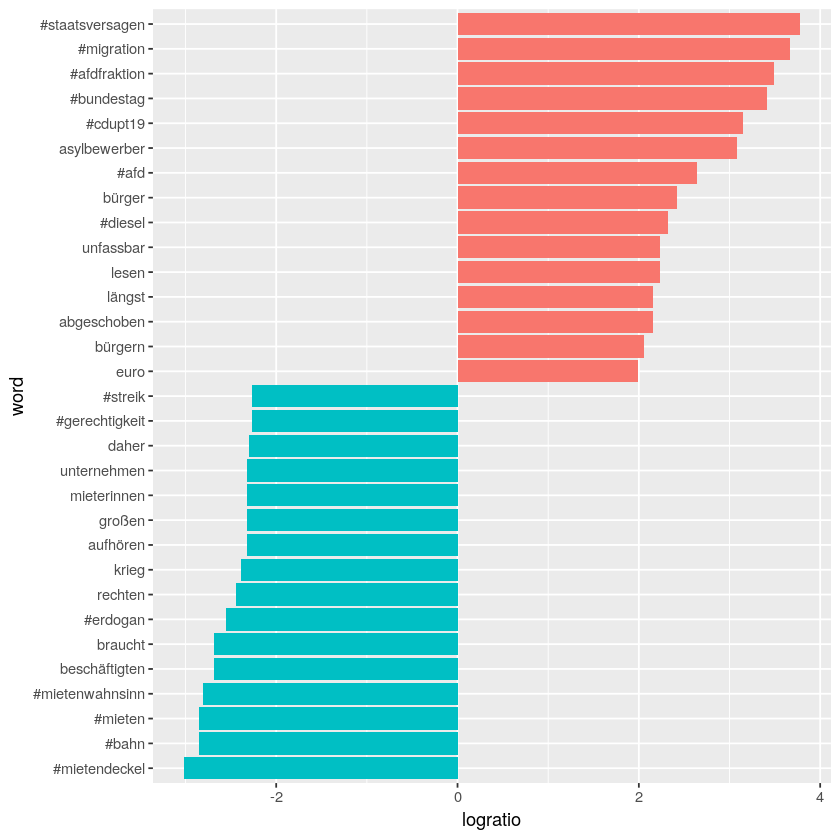

In [12]:
tidy_tweets %>%
  filter(!str_detect(word, "^@")) %>%
  count(word, collection) %>%
  group_by(word) %>%
  filter(sum(n) >= 10) %>%
  ungroup() %>%
  spread(collection, n, fill = 0) %>%
  mutate_if(is.numeric, list(~(. + 1) / (sum(.) + 1))) %>%
  mutate(logratio = log(Alice_Weidel / b_riexinger)) %>%
  arrange(desc(logratio)) %>%
  group_by(logratio < 0) %>%
  top_n(15, abs(logratio)) %>%
  ungroup() %>%
  mutate(word = reorder(word, logratio)) %>%
  ggplot(aes(word, logratio, fill = logratio < 0)) +
  geom_col(show.legend = FALSE) +
  coord_flip()